# buzzard async rasters 

⚠️ Watch out, some features are not yet implemented!

In [1]:
%matplotlib inline

# Part 1: A raster file configured to be read asynchronously

 By default in *buzzard* when calling `get_data()` on a raster file opened normally, all the data is read from disk at once (using one `gdal.Band.ReadAsArray()` for example), and all the optional resampling is then performed in one step (using one `cv2.remap()` for example). When performing this operation on a large chunk of data, it would be much more efficient to read and resample __tile by tile to parallelize__ those tasks. To do so, use `async_=True` in `open_raster()` and `create_raster()`.

Another feature unlocked by using an _async raster_ to read a file is the `iter_data()` method. Compared to the `get_data()` method that takes a _Footprint_ and return an _ndarray_, this new method takes a _list of Footprint_ and return an _iterator of ndarray_. By using this method the next array to be yielded is prepared in priority and the next ones are also prepared at the same time if there are enough workers available. You can control how much arrays can be made available in advance by setting the optional `max_queue_size=5` parameter of the `iter_data()` method, this allows you to __prevent backpressure__ if you consume the _iterator of ndarray_ too slowly.

As seen before, the `async_` parameter can be a _boolean_, but instead of `True` you can also pass a _dict of options_ to parameterize how the raster is handled in the background. Some options control the amount of chunking to perform for the read and resampling steps, some other options allow you to choose the two _thread pools_ that will be used for reading and resampling. By default a single pool is shared by all _async rasters_ for _io_ operations (like reading a file), and another pool is shared for cpu intensive operations (like resampling).

This kind of __ressource sharing__ between rasters is not trivial and requires some synchronization. To do so, a thread (called the _scheduler_) is spawned in the `Dataset` to manage the queries to rasters. As you will see in the next parts, the _scheduler_ is able to manage other kind of rasters.


In [2]:
# %load ./part1.py
import time
import os

import buzzard as buzz

import example_tools

def main():
    path = example_tools.create_random_elevation_gtiff()
    ds = buzz.Dataset(allow_interpolation=True)

    print('Classic opening')
    # Features:
    # - Disk reads are not tiled
    # - Resampling operations are not tiled
    with ds.aopen_raster(path).close as r:
        test_raster(r)

    return # The NEXT features are not yet implemented

    print('Opening within scheduler')
    # Features:
    # - Disk reads are automatically tiled and parallelized
    # - Resampling operations are automatically tiled and parallelized
    # - `iter_data()` method is available
    with ds.aopen_raster(path, async_=True).close as r:
        # `async_=True` is equivalent to
        # `async_={}`, and also equivalent to
        # `async_={io_pool='io', resample_pool='cpu', max_resampling_size=512, max_read_size=512}`
        test_raster(r)

    # `Dataset.close()` closes all rasters, the scheduler, and the pools.
    # If you let the garbage collector collect the `Dataset`, the rasters and
    # the scheduler will be correctly closed, but the pools will leak memory.
    ds.close()

    os.remove(path)

def test_raster(r):
    """Basic testing functions. It will be reused throughout those tests"""
    print('| Print raster informations')
    fp = r.fp
    if r.get_keys():
        print(f'|   key: {r.get_keys()[0]}')
    print(f'|   type: {type(r).__name__}')
    print(f'|   dtype: {r.dtype}, band-count: {len(r)}')
    print(f'|   Footprint: center:{fp.c}, scale:{fp.scale}')
    print(f'|              size(m):{fp.size}, raster-size(px):{fp.rsize}')
    fp_lowres = fp.intersection(fp, scale=fp.scale * 2)

    # *********************************************************************** **
    print('| Test 2 - Getting the full raster')
    with example_tools.Timer() as t:
        arr = r.get_data(band=-1)
    print(f'|   took {t}, {fp.rarea / float(t):_.0f} pixel/sec')

    # *********************************************************************** **
    print('| Test 3 - Getting and downsampling the full raster')
    with example_tools.Timer() as t:
        arr = r.get_data(fp=fp_lowres, band=-1)
    print(f'|   took {t}, {fp_lowres.rarea / float(t):_.0f} pixel/sec')

    # *********************************************************************** **
    print('| Test 4 - Getting the full raster in 9 tiles with a slow main'
          'thread')
    tiles = fp.tile_count(3, 3, boundary_effect='shrink').flatten()
    if hasattr(r, 'iter_data'):
        # Using `iter_data` of async rasters
        arr_iterator = r.iter_data(tiles, band=-1)
    else:
        # Making up an `iter_data` for classic rasters
        arr_iterator = (
            r.get_data(fp=tile, band=-1)
            for tile in tiles
        )
    with example_tools.Timer() as t:
        for tile, arr in zip(tiles, arr_iterator):
            time.sleep(1 / 9)
    print(f'|   took {t}, {r.fp.rarea / float(t):_.0f} pixel/sec')

if __name__ == '__main__':
    main()


Classic opening
| Print raster informations
|   type: GDALFileRaster
|   dtype: float32, band-count: 1
|   Footprint: center:[ 863.77661732 -150.27534036], scale:[ 0.03 -0.03]
|              size(m):[480. 480.], raster-size(px):[16000 16000]
| Test 2 - Getting the full raster
|   took 0.7879 sec, 324_927_526 pixel/sec
| Test 3 - Getting and downsampling the full raster
|   took 6.1051 sec, 10_483_078 pixel/sec
| Test 4 - Getting the full raster in 9 tiles with a slow mainthread
|   took 1.5586 sec, 164_247_860 pixel/sec


# Part 2: Deriving the _slopes_ from a _dem_ using a _raster recipe_

In _buzzard_ there are 3 types of raster managed by the _Dataset_'s scheduler:
- _AsyncStoredRaster_, seen in `Part 1`,
- _NocacheRasterRecipe_, seen in this part,
- _CachedRasterRecipe_, seen in `Part 4`.

All those rasters are called _async rasters_.

### A new type of raster: _recipes_
A _recipe_ is an _async raster_ that __computes data on the fly__ by calling the `compute_array` function provided in the constructor. This function takes a _Footprint_ that defines a rectangle to compute, and it returns a _ndarray_ containing the pixels computed at this location. This function will be called in parallel given the `computation_pool` parameter provided in the constructor.

A _recipe_ may __depend on some other *async rasters*__. In this example, `ds.slopes` is a _NocacheRasterRecipe_ that depends on `ds.elevation`, an _AsyncStoredRaster_. To declare the dependancy of `ds.slopes` on `ds.elevation`, in the constructor of `ds.slopes` you must provide `queue_data_per_primitive={'some_key': ds.elevation.queue_data}`, to allow the *scheduler* to issue queries to elevation when the slopes requires it. The `compute_array` function of `ds.slopes` will take as parameter the _ndarray_ of `ds.dem` automatically extracted.

A _recipe_ may depend on more than one _async raster_, and a _recipe_ that depends on an _async raster_ may also be needed by another recipe. This means that recipes can be assembled to form __computation graphs__ of any width and any depth.

### Parallelization within _async rasters_
The computation intensive and io-bound steps of the scheduler are __defered to thread pools__ by default. You can configure the pools in the _async rasters_ constructors. Those parameters can be of the following types:
- A _multiprocessing.pool.ThreadPool_, should be the default choice.
- A _multiprocessing.pool.Pool_, a process pool. Useful for computations that requires the [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock) or that leaks memory.
- `None`, to request the scheduler thread to perform the tasks itself. Should be used when the computation is very light.
- A _hashable_ (like a _string_), that will map to a pool registered in the _Dataset_. If that key is missing from the _Dataset_, a _ThreadPool_ with `multiprocessing.cpu_count()` workers will be automatically instanciated.


In [3]:
# %load ./part2.py
import os
import time
import multiprocessing as mp
import multiprocessing.pool

import buzzard as buzz
import numpy as np
import scipy.ndimage

import example_tools
from part1 import test_raster

def main():
    return # None of the features shown here are implemented yet
    path = example_tools.create_random_elevation_gtiff()
    ds = buzz.Dataset()

    # Pool to parallelize:
    # - `ds.slopes` computations
    # - `ds.elevation` resamplings
    cpu_pool = mp.pool.ThreadPool(mp.cpu_count())

    # Pool to parallelize:
    # - `ds.elevation` disk reads
    io_pool = mp.pool.ThreadPool(4)

    ds.open_raster(
        'elevation',
        path=path,
        async_={'io_pool': io_pool, 'resample_pool': cpu_pool},
    )
    ds.create_raster_recipe(
        'slopes',
        computation_pool=cpu_pool,

        # The next 6 lines can be replaced by **buzz.algo.slopes(ds.elevation)
        fp=ds.elevation.fp,
        dtype='float32',
        channel_count=1,
        compute_array=slopes_of_elevation,
        queue_data_per_primitive={'dem': ds.elevation.queue_data},
        convert_footprint_per_primitive={'dem': lambda fp: fp.dilate(1)},
    )

    # Test 1 - Perform basic tests ****************************************** **
    # `test_raster` will request `slopes`'s' pixels. `elevation`'s' pixels will
    # be requested in cascade and then used to compute the `slopes`.
    test_raster(ds.slopes)

    # Test 2 - Multiple iterations at the same time ************************* **
    # Here the `elevation` raster is directly requested and also requested by
    # the `slopes`, the Dataset's scheduler is made to handle simultaneous
    # queries.
    tiles = ds.elevation.fp.tile_count(2, 2).flatten()
    dem_iterator = ds.elevation.iter_data(tiles)
    slopes_iterator = ds.slopes.iter_data(tiles)
    for tile, dem, slopes in zip(tiles, dem_iterator, slopes_iterator):
        print(f'Showing dem and slopes at:\n {tile}')
        example_tools.show_several_images(
            ('elevation (dem)', tile, dem),
            ('slopes', tile, slopes),
        )

    # Test 3 - Backpressure prevention ************************************** **
    tiles = ds.slopes.tile_count(3, 3).flatten()

    print('Creating a slopes iterator on 9 tiles')
    it = ds.slopes.iter_data(tiles, max_queue_size=1)
    print('  At most 5 dem arrays can be ready between `ds.elevation` and '
          '`ds.slopes`')
    print('  At most 1 slopes array can be ready out of the slopes iterator')

    print('Sleeping several seconds to let the scheduler create 6 of the 9 '
          'dem arrays, and 1 of the 9 slopes arrays.')
    time.sleep(4)

    with example_tools.Timer() as t:
        arr = next(it)
    print(f'Getting the first array took {t}, this was instant because it was '
          'ready')

    with example_tools.Timer() as t:
        for _ in range(5):
            next(it)
    print(f'Getting the next 5 arrays took {t}, it was quick because the dems '
          'were ready')

    with example_tools.Timer() as t:
        for _ in range(3):
            next(it)
    print(f'Getting the last 4 arrays took {t}, it was long because nothing was'
          ' ready')

    # Cleanup *************************************************************** **
    ds.close()
    os.remove(path)

def slopes_of_elevation(fp, primitive_fps, primitive_arrays, slopes):
    """A function to be fed to `compute_array` when constructing a recipe"""
    arr = primitive_arrays['dem']
    kernel = [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ]
    arr = (
        scipy.ndimage.maximum_filter(arr, None, kernel) -
        scipy.ndimage.minimum_filter(arr, None, kernel)
    )
    arr = arr[1:-1, 1:-1]
    arr = np.arctan(arr / fp.pxsizex)
    arr = arr / np.pi * 180.
    return arr

if __name__ == '__main__':
    main()


# Part 3: *Mandelbrot* set computed on the fly

### Automatic remapping
When creating a recipe you give a _Footprint_ through the `fp` parameter. When calling your `compute_array` function the scheduler will only ask for slices of `fp`. This means that the scheduler takes care of those boilerplate steps:
- If you request a *Footprint* on a different grid in a `get_data()` call, the scheduler __takes care of resampling__ the outputs of your `compute_array` function.
- If you request a *Footprint* partially or fully outside of the raster's extent, the scheduler will call your `compute_array` function to get the interior pixels and then __pad the output with nodata__.

This system is flexible and can be deactivated by passing `automatic_remapping=False` to the constructor of a _NocacheRasterRecipe_, in this case the scheduler will call your `compute_array` function for any kind of _Footprint_; thus your function must be able to comply with any request. In `Part 2` the slopes could have been opened that way without changing the rest of the code, the resampling operations would have been deferred to the `elevation` raster.

In the following example `mand_100px`, `mand_10kpx`, `mand_1mpx`, `mand_100mpx`, `mand_10gpx`, `mand_1tpx` are instanciated with automatic remapping, and `ds.mand` is instanciated without.

### Chunking computations
In the following example the pixels are very long to compute, `max_computation_size=128` is passed to ask the _scheduler_ to call `compute_array` with _Footprints_ of at most 128x128 pixels. This option allows even more parallelism.

Instead of using `max_computation_size` you can also use `computation_tiles` to chunk the computations. This parameter should contain a tiling of the raster's _Footprint_ (See `Footprint.tile*` methods), doing so will tell the scheduler to only call `compute_array` with _Footprints_ from `computation_tiles`, the computations will be **automatically stiched** to form the requested outputs. This constrain is essential if the `compute_array` function hides a call to a *convolutional neural network*. This parameter is demoed in `part 5`.


In [4]:
# %load ./part3.py
import buzzard as buzz
import numpy as np
from numba import jit
import shapely.geometry

import example_tools
from part1 import test_raster

def main():
    return # None of the features shown here are implemented yet
    ds = buzz.Dataset(allow_interpolation=True)
    pixel_per_line = {
        'mand_100px': 10,
        'mand_10kpx': 100,
        'mand_1mpx': 1_000,
        'mand_100mpx': 10_000,
        'mand_10gpx': 100_000,
        'mand_1tpx': 1_000_000,
    }

    # Instanciate 6 fixed scale mandelbrot rasters
    for key, rwidth in pixel_per_line.items():
        # Create a Footprint that ranges from -2 to 2 on both x and y axes
        fp = buzz.Footprint(
            gt=(-2, 4 / rwidth, 0, -2, 0, 4 / rwidth),
            rsize=(rwidth, rwidth),
        )
        ds.create_raster_recipe(
            key,
            fp=fp,
            dtype='float32',
            channel_count=1,
            compute_array=mandelbrot_of_footprint,
            automatic_remapping=True, # True is the default value
            max_computation_size=128,
        )

    # Instanciate 1 flexible scale mandelbrot raster
    # The fp parameter does not mean much when `automatic_remapping=False`, but
    # it is still mandatory.
    ds.create_raster_recipe(
        'mand',
        fp=ds.mand_10kpx.fp,
        dtype='float32',
        channel_count=1,
        compute_array=mandelbrot_of_footprint,
        automatic_remapping=False,
        max_computation_size=128,
    )

    # Test 1 - Perform basic tests ****************************************** **
    test_raster(ds.mand_100px)
    test_raster(ds.mand_10kpx)
    test_raster(ds.mand_1mpx)

    # Test 2 - Play with resampling with the non-flexible scale rasters ***** **
    fp100k = buzz.Footprint(
        gt=(-2, 4 / 316, 0, -2, 0, 4 / 316),
        rsize=(316, 316),
    )
    example_tools.show_several_images(
        ('10kpx', ds.mand_10kpx.fp, ds.mand_10kpx.get_data()),
        ('1mpx', ds.mand_1mpx.fp, ds.mand_1mpx.get_data()),
        ('10kpx to 100kpx', fp100k, ds.mand_10kpx.get_data(fp=fp100k)), # upsample * 10
        ('1mpx to 100kpx', fp100k, ds.mand_1mpx.get_data(fp=fp100k)), # downsample * 10
    )

    # Test 3 - Play with with the flexible scale raster ********************* **
    example_tools.show_several_images(
        ('10kpx', ds.mand_10kpx.fp, ds.mand.get_data(fp=ds.mand_10kpx.fp)),
        ('1mpx', ds.mand_1mpx.fp, ds.mand.get_data(fp=ds.mand_1mpx.fp)),
    )

    # Test 4 - Zoom to a point ********************************************** **
    focus = shapely.geometry.Point(-1.1172, -0.221103)
    for key in pixel_per_line.items():
        fp = ds[key].fp
        fp = fp.dilate(250) & focus.buffer(fp.pxsizex * 250)
        arr = ds[key].get_data(fp=fp)
        title = f'{fp.rw}x{fp.rh} rect of the {key} image'
        example_tools.show_several_images((title, fp, arr))

    ds.close()

def mandelbrot_of_footprint(fp, *_):
    """A function to be fed to `compute_array` when constructing a recipe"""
    maxit = int(np.ceil((4 / fp.pxsizex)))
    array = np.empty(fp.shape, 'uint32')
    mandelbrot_jit(array, fp.tl, fp.scale, maxit)
    array = array.astype('float32') / maxit
    return array

@jit(nopython=True, nogil=True, cache=True)
def mandelbrot_jit(array, tl, scale, maxit):
    """Compute a https://en.wikipedia.org/wiki/Mandelbrot_set"""
    for j in range(array.shape[0]):
        y0 = tl[1] + j * scale[1]
        for i in range(array.shape[1]):
            x0 = tl[0] + i * scale[0]
            x, y, x2, y2 = 0., 0., 0., 0.
            iteration = 0
            while x2 + y2 < 4 and iteration < maxit:
                y = 2 * x * y + y0
                x = x2 - y2 + x0
                x2 = x * x
                y2 = y * y
                iteration += 1
            array[j][i] = iteration

if __name__ == '__main__':
    # Using `allow_complex_footprint` because we are instanciating Footprints
    # with `fp.scale[1] > 0`
    with buzz.Env(allow_complex_footprint=True):
        main()


# Part 4: Mandelbrot 10 mega pixels computed on the fly and cached on disk

By using the Dataset.create_cached_raster_recipe factory you can create a recipe that caches the results tile by tile in a directory.

The CachedRasterRecipe takes two tilings of the raster's Footprint as parameter, those tilings can be computed by using the `tile*` methods of the Footprint class:
- The `cache_tiles` tiling will define what pixels go into which cache file. To correctly reopen a cached raster after closing it the `cache_tiles` parameter should be identical from the time it was created. A cache file is saved with its checksum stored in its file name, if a cache file was corrupted in any way between two openings <talk about ctrl-c in previous invocation>, the file will be removed and recomputed. By default tiles of size 512x512 are generated.
- The `computation_tiles` tiling defines the exhaustive set of Footprints that can be queried to the `compute_array` function. This can for example be used to get some overlap in the computations or to enforce a constant size in the Footprints to compute. By default this tiling will be the same as `cache_tiles`.


Test 1 - Read mandelbrot 100mpx twice and compare timings
Getting Footprint at [-1.1172 -0.221 ]...
  took 2.6693 sec
Getting Footprint at [-1.1172 -0.221 ]...
  took 0.1218 sec
Tiles in `mandelbrot_100mpx_tiles` directory:
- mandelbrot_100mpx_tiles/buzz_x004-y008_x02048-y04096_927ed3192d162cda.tif
- mandelbrot_100mpx_tiles/buzz_x003-y008_x01536-y04096_dec45517c24990c4.tif
- mandelbrot_100mpx_tiles/buzz_x003-y009_x01536-y04608_d25e0d0045ae1f28.tif
- mandelbrot_100mpx_tiles/buzz_x004-y009_x02048-y04608_43c1f10fed1edd6c.tif

Test 2 - Corrupt one cache file and try to reuse the file
Corrupting mandelbrot_100mpx_tiles/buzz_x004-y008_x02048-y04096_927ed3192d162cda.tif...


Removing mandelbrot_100mpx_tiles/buzz_x004-y008_x02048-y04096_927ed3192d162cda.tif because invalid checksum (927f054da5162cda instead of 927ed3192d162cda)


Getting Footprint at [-1.1172 -0.221 ]...


/home/rb-desktop-10/buzz/buzzard/buzzard/_actors/cached/file_checker.py:130: RuntimeWarning: overflow encountered in ulong_scalars
  acc += head


  took 1.0089 sec


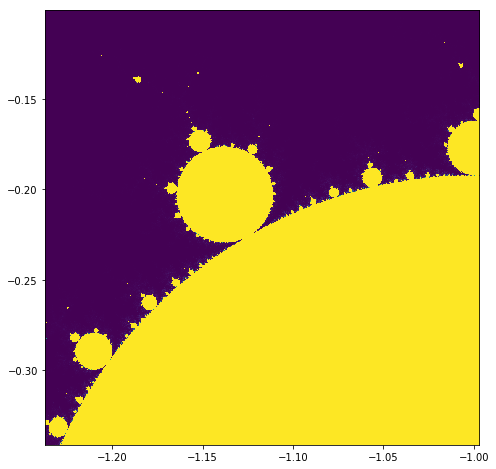

In [5]:
# %load ./part4.py
import os

import buzzard as buzz
import numpy as np
import shapely.geometry

import example_tools
from part3 import mandelbrot_of_footprint

CACHE_DIR = 'mandelbrot_100mpx_tiles'

def colorize_mandelbrot(fp, primitive_fps, primitive_arrays, raster):
    arr = primitive_arrays['mand']

    # Colorize converging pixels
    arr[arr == 1.] = 0.

    # Colorize diverging pixels
    maxit = 4 / fp.pxsizex
    arr = np.floor((arr * maxit * 7.) % 256.)
    # arr = np.floor((maxit * 100. / arr) % 256.)

    # Turn to rgb
    res = np.zeros(np.r_[fp.shape, 3], 'uint8')
    res[..., 0] = arr
    return res

def example():
    ds = buzz.Dataset()

    # Create a Footprint that ranges from -2 to 2 on both x and y axes
    fp = buzz.Footprint(
        gt=(-2, 4 / 10000, 0, -2, 0, 4 / 10000),
        rsize=(10000, 10000),
    )
    cache_tiling = fp.tile((512, 512), boundary_effect='shrink')
    computation_tiling = fp.tile((128, 128), boundary_effect='shrink')
    cached_recipe_params = dict(
        key='mand_100mpx',

        fp=fp,
        dtype='float32',
        channel_count=1,
        compute_array=mandelbrot_of_footprint,

        cache_dir=CACHE_DIR,
        cache_tiles=cache_tiling,
        computation_tiles=computation_tiling,
    )
    ds.create_cached_raster_recipe(**cached_recipe_params)

    # Test 1 - Timings before and after caching ***************************** **
    print('Test 1 - Read mandelbrot 100mpx twice and compare timings')
    fp = ds.mand_100mpx.fp
    fp = fp & shapely.geometry.Point(-1.1172, -0.221103).buffer(fp.pxsizex * 300)
    print(f'Getting Footprint at {fp.c}...')
    with example_tools.Timer() as t:
        ds.mand_100mpx.get_data(fp=fp)
    print(f'  took {t}')

    print(f'Getting Footprint at {fp.c}...')
    with example_tools.Timer() as t:
        ds.mand_100mpx.get_data(fp=fp)
    print(f'  took {t}')
    print('Tiles in `{}` directory:\n- {}'.format(
        CACHE_DIR,
        '\n- '.join(example_tools.list_cache_files_path_in_dir(CACHE_DIR)),
    ))
    print()

    # Test 2 - Corrupt one cache file and try to reuse the file ************* **
    print('Test 2 - Corrupt one cache file and try to reuse the file')
    ds.mand_100mpx.close()

    # Pick one cache file and append one byte to it
    one_cache_tile_path = example_tools.list_cache_files_path_in_dir(CACHE_DIR)[0]
    print(f'Corrupting {one_cache_tile_path}...')
    with open(one_cache_tile_path, 'ba') as f:
        f.write(b'\0x42')
    ds.create_cached_raster_recipe(**cached_recipe_params)

    print(f'Getting Footprint at {fp.c}...')
    with example_tools.Timer() as t:
        arr = ds.mand_100mpx.get_data(fp=fp)
    print(f'  took {t}')

    example_tools.show_several_images((
        'part of mandelbrot 100 mega pixels',
        fp,
        arr,
    ))

    return # The NEXT features are not yet implemented

    # Test 4 - Colorize mandelbrot 100mpx ************************************ **
    ds.create_raster_recipe(
        'mand_red',
        fp=fp,
        dtype='uint8',
        channel_count=3,
        compute_array=colorize_mandelbrot,
        queue_data_per_primitive={'mand': ds.mand_100mpx.queue_data},
        computation_tiles=computation_tiling,
        automatic_remapping=False,
    )
    example_tools.show_several_images((
        'part of mandelbrot 10 mega pixels in red',
        fp,
        ds.mand_red.get_data(fp=fp),
    ))

if __name__ == '__main__':
    if os.path.isdir(CACHE_DIR):
        for path in example_tools.list_cache_files_path_in_dir(CACHE_DIR):
            os.remove(path)
    with buzz.Env(allow_complex_footprint=True):
        example()


# Part 5 - Caching downloads

Any kind of operations can be performed in a computation function, including downloading.

### Credits
All images shown here belong to ESA/Hubble. See spacetelescope.org.


All images shown here belong to ESA/Hubble. See spacetelescope.org.

  Opening andromeda at zoom 0, 135x43 pixels split between 1 files
  Opening andromeda at zoom 1, 271x86 pixels split between 2 files
  Opening andromeda at zoom 2, 543x173 pixels split between 3 files
  Opening andromeda at zoom 3, 1086x347 pixels split between 10 files
  Opening andromeda at zoom 4, 2173x694 pixels split between 27 files
  Opening andromeda at zoom 5, 4346x1389 pixels split between 102 files
  Opening andromeda at zoom 6, 8692x2778 pixels split between 374 files
  Opening andromeda at zoom 7, 17384x5557 pixels split between 1496 files

Test 1 - Show andromeda with 3 resolutions
| Print raster informations
|   key: andromeda_zoom0
|   type: CachedRasterRecipe
|   dtype: uint8, band-count: 3
|   Footprint: center:[0. 0.], scale:[ 512. -512.]
|              size(m):[69120. 22016.], raster-size(px):[135  43]
| Test 2 - Getting the full raster
|   took 0.2710 sec, 21_422 pixel/sec
| Test 3 - Getting and 

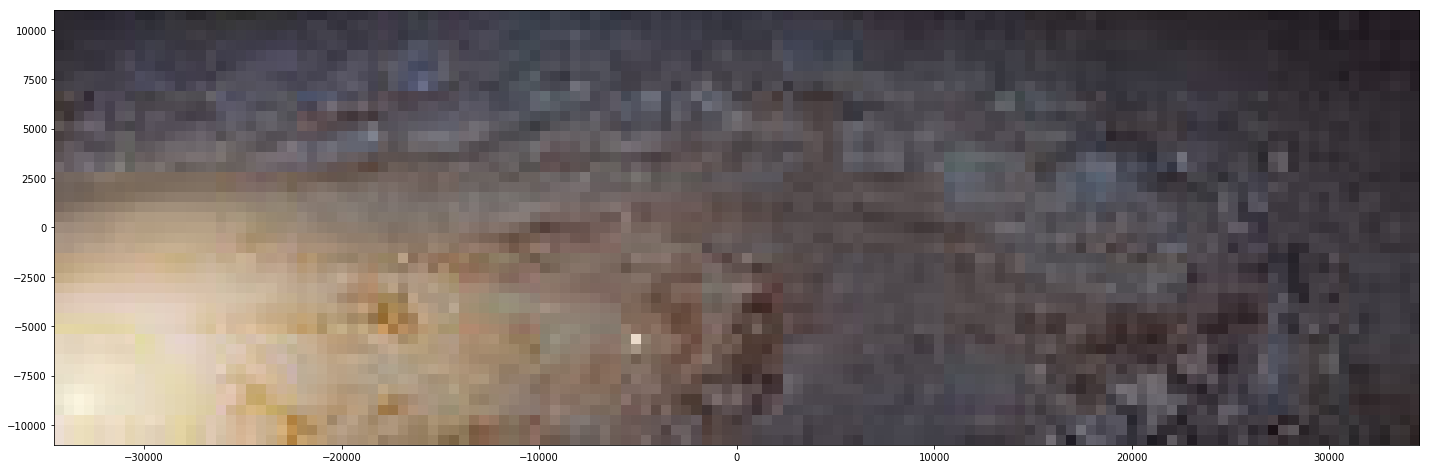


| Print raster informations
|   key: andromeda_zoom1
|   type: CachedRasterRecipe
|   dtype: uint8, band-count: 3
|   Footprint: center:[0. 0.], scale:[ 256. -256.]
|              size(m):[69376. 22016.], raster-size(px):[271  86]
| Test 2 - Getting the full raster
|   took 0.2359 sec, 98_808 pixel/sec
| Test 3 - Getting and downsampling the full raster
|   took 0.1701 sec, 34_380 pixel/sec
| Test 4 - Getting the full raster in 9 tiles with a slow mainthread
|   took 1.0962 sec, 21_262 pixel/sec


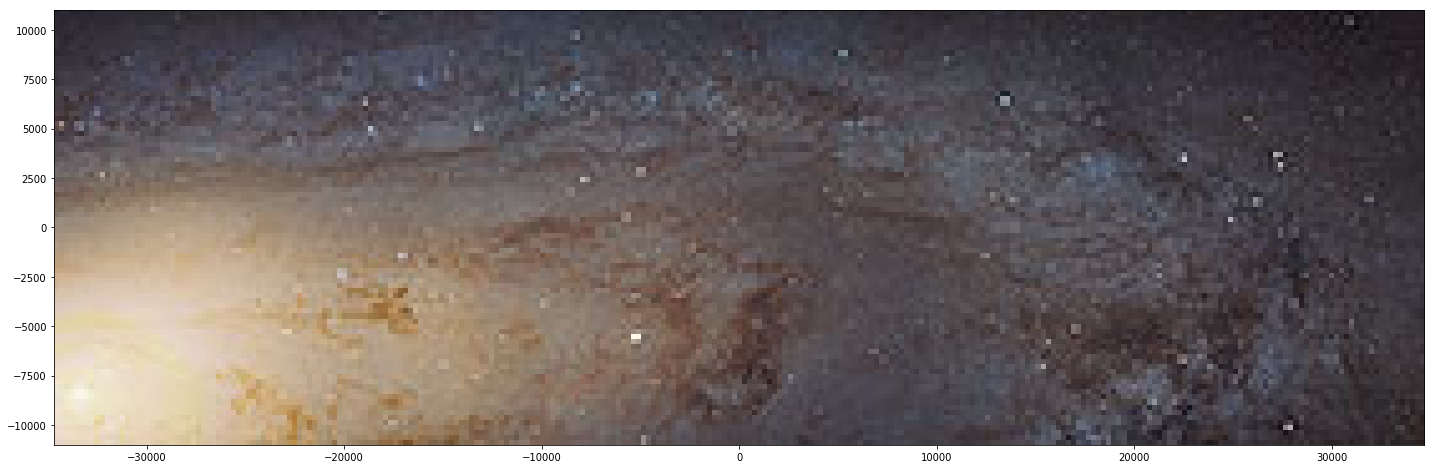


| Print raster informations
|   key: andromeda_zoom2
|   type: CachedRasterRecipe
|   dtype: uint8, band-count: 3
|   Footprint: center:[0. 0.], scale:[ 128. -128.]
|              size(m):[69504. 22144.], raster-size(px):[543 173]
| Test 2 - Getting the full raster
|   took 0.2949 sec, 318_496 pixel/sec
| Test 3 - Getting and downsampling the full raster
|   took 0.1738 sec, 136_142 pixel/sec
| Test 4 - Getting the full raster in 9 tiles with a slow mainthread
|   took 1.1089 sec, 84_711 pixel/sec


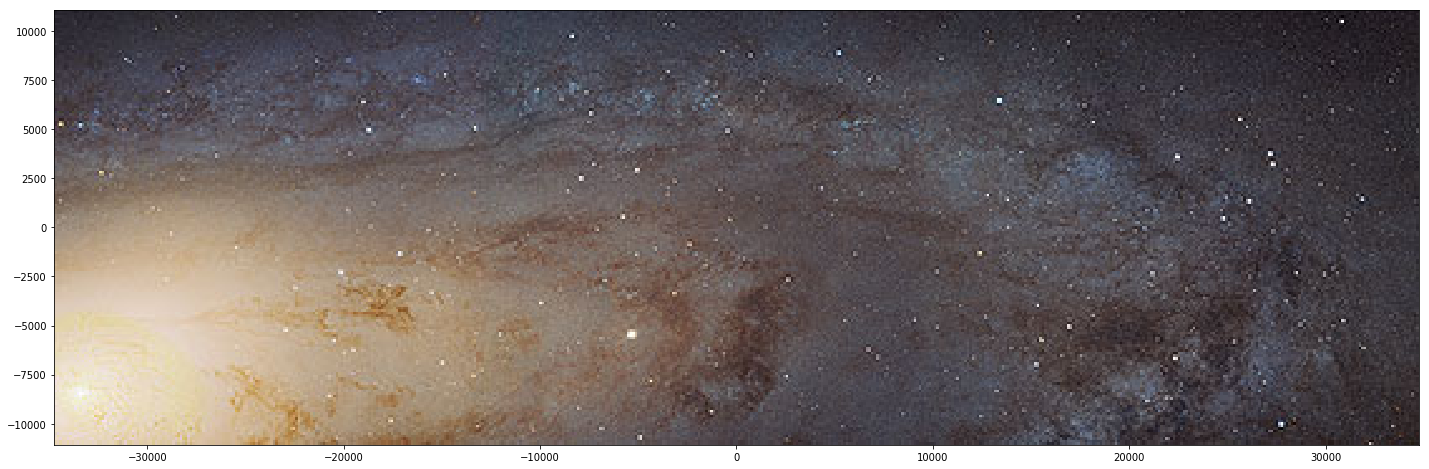



Test 2 - Read andromeda 4 times and compare timings
Getting andromeda_zoom5 took 3.0915 sec, download was performed
Getting andromeda_zoom5 took 0.5761 sec, data was directly fetched from cache
Closing and opening andromeda rasters again...
  Opening andromeda at zoom 0, 135x43 pixels split between 1 files
  Opening andromeda at zoom 1, 271x86 pixels split between 2 files
  Opening andromeda at zoom 2, 543x173 pixels split between 3 files
  Opening andromeda at zoom 3, 1086x347 pixels split between 10 files
  Opening andromeda at zoom 4, 2173x694 pixels split between 27 files
  Opening andromeda at zoom 5, 4346x1389 pixels split between 102 files
  Opening andromeda at zoom 6, 8692x2778 pixels split between 374 files
  Opening andromeda at zoom 7, 17384x5557 pixels split between 1496 files
Getting andromeda_zoom5 took 0.7397 sec, cache files validity was checked and data was fetched from cache
Getting andromeda_zoom5 took 0.5358 sec, data was directly fetched from cache


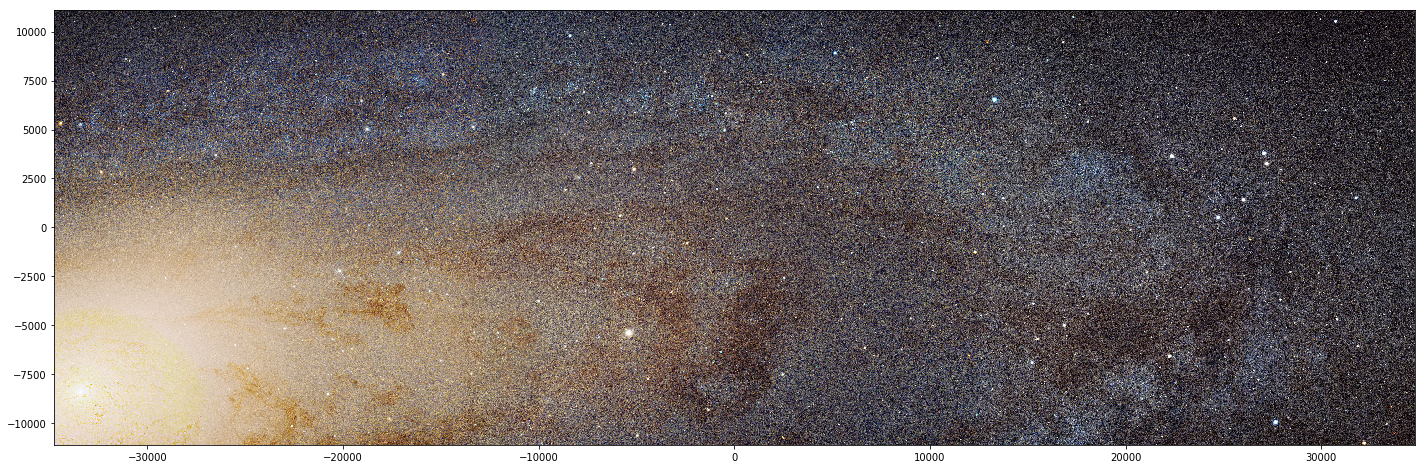


Test 2 - Show monocerotis
  Opening monocerotis at zoom 0, 212x211 pixels split between 1 files
  Opening monocerotis at zoom 1, 425x422 pixels split between 4 files
  Opening monocerotis at zoom 2, 850x845 pixels split between 16 files
  Opening monocerotis at zoom 3, 1700x1691 pixels split between 49 files
  Opening monocerotis at zoom 4, 3400x3382 pixels split between 196 files


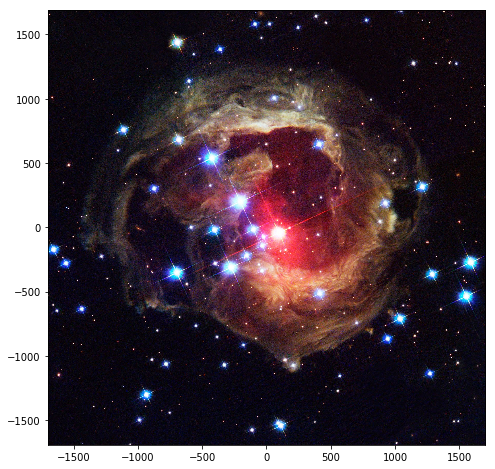

In [6]:
# %load ./part5.py
import functools
import os
import multiprocessing as mp
import multiprocessing.pool

import buzzard as buzz
import numpy as np
import skimage.io

import example_tools

from part1 import test_raster

ZOOMABLE_URLS = {
    'andromeda': 'https://cdn.spacetelescope.org/archives/images/zoomable/heic1502a/',
    'monocerotis': 'https://cdn.spacetelescope.org/archives/images/zoomable/heic0503a/',

}
DOWNLOAD_POOL = mp.pool.ThreadPool(5)

def main():
    print("All images shown here belong to ESA/Hubble. See spacetelescope.org.\n")

    ds = buzz.Dataset(allow_interpolation=True)
    open_zoomable_rasters(ds, 'andromeda', overwrite=True)

    # Test 1 - Perform basic tests ****************************************** **
    print()
    print('Test 1 - Show andromeda with 3 resolutions')
    test_raster(ds.andromeda_zoom0)
    example_tools.show_several_images((
        'andromeda_zoom0', ds.andromeda_zoom0.fp,
        ds.andromeda_zoom0.get_data(band=-1)
    ))
    print()

    test_raster(ds.andromeda_zoom1)
    example_tools.show_several_images((
        'andromeda_zoom1', ds.andromeda_zoom1.fp,
        ds.andromeda_zoom1.get_data(band=-1)
    ))
    print()

    test_raster(ds.andromeda_zoom2)
    example_tools.show_several_images((
        'andromeda_zoom2', ds.andromeda_zoom2.fp,
        ds.andromeda_zoom2.get_data(band=-1)
    ))
    print()

    # Test 2 - Test `get_data` timings ************************************** **
    print()
    print('Test 2 - Read andromeda 4 times and compare timings')
    with example_tools.Timer() as t:
        ds.andromeda_zoom5.get_data(band=-1)
    print(f'Getting andromeda_zoom5 took {t}, download was performed')

    with example_tools.Timer() as t:
        ds.andromeda_zoom5.get_data(band=-1)
    print(f'Getting andromeda_zoom5 took {t}, data was directly fetched from cache')

    print('Closing and opening andromeda rasters again...')
    ds.close()
    ds = buzz.Dataset(allow_interpolation=True)
    open_zoomable_rasters(ds, 'andromeda', overwrite=False)

    with example_tools.Timer() as t:
        ds.andromeda_zoom5.get_data(band=-1)
    print(f'Getting andromeda_zoom5 took {t}, cache files validity was checked'
          ' and data was fetched from cache')

    with example_tools.Timer() as t:
        ds.andromeda_zoom5.get_data(band=-1)
    print(f'Getting andromeda_zoom5 took {t}, data was directly fetched from cache')

    example_tools.show_several_images((
        'andromeda_zoom5', ds.andromeda_zoom5.fp,
        ds.andromeda_zoom5.get_data(band=-1)
    ))

    # Test 3 **************************************************************** **
    print()
    print('Test 2 - Show monocerotis')
    open_zoomable_rasters(ds, 'monocerotis', overwrite=False)
    example_tools.show_several_images((
        'monocerotis_zoom3', ds.monocerotis_zoom3.fp,
        ds.monocerotis_zoom3.get_data(band=-1)
    ))

def open_zoomable_rasters(ds, name, overwrite):
    infos = example_tools.infos_of_zoomable_url(
        ZOOMABLE_URLS[name], max_zoom=8, verbose=False,
    )
    for zoom_level, (fp, tiles, url_per_tile) in enumerate(zip(*infos)):
        print('  Opening {} at zoom {}, {}x{} pixels split between {} files'.format(
            name, zoom_level, *fp.rsize, tiles.size,
        ))
        ds.create_cached_raster_recipe(
            key=f'{name}_zoom{zoom_level}',

            fp=fp,
            dtype='uint8',
            channel_count=3,
            compute_array=functools.partial(
                download_tile,
                url_per_tile=url_per_tile
            ),
            computation_pool=DOWNLOAD_POOL,

            cache_tiles=tiles,
            cache_dir=f'{name}_zoom{zoom_level}',
            ow=overwrite,
        )

def download_tile(fp, *_, url_per_tile):
    """A function to be fed to `compute_array` when constructing a recipe"""
    url = url_per_tile[fp]
    arr = skimage.io.imread(url)
    return arr

if __name__ == '__main__':
    with buzz.Env(allow_complex_footprint=True):
        main()
